<a href="https://colab.research.google.com/github/jdmartinev/ST1613-AppliedML-/blob/main/Semana01/Predicci%C3%B3n_de_abandono_de_clientes_con_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial**

En este tutorial, analizará una base de datos de predicción de abandono de clientes [*Telco customer churn*](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

![Churn prediction](https://drive.google.com/uc?id=1B0Ml6NVK0MAfJvvPIX-KPA3d4rmAgRjX)


## **Descarga de datos**

Lo primero que hará será descargar los datos con los que va a trabajar:

- Tabla de datos de clientes (archivo csv).

Estos archivos quedarán en la carpeta _/content/data.csv asociada con el sistema operativo del servidor en el que se está ejecutando google colab.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1d6iPtgmKM5N2mtrWFb-SzLdGCwLWmxF9' -O data.csv


### Importar las librerías necesarias

Importe las librerías que le servirán para el procesamiento y visualización de datos. 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## **1. Procesamiento básico**

En este primer paso, cargará la base de datos (archivo .csv) a un _dataframe_ de pandas y utilizará algunas funciones de la librería que le ayudarán a tener información básica de los datos. De forma resumida, un _dataframe_ de pandas es una estructura de datos bidimensional en la que los datos se organizan en filas y columnas. Es similar a una hoja de cálculo en Excel, donde cada columna representa una variable y cada fila representa una observación.


In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.shape #Tamaño de la tabla (df.shape[0] es el número de filas y df.shape[1] es el número de columnas)

(7043, 21)

In [ ]:
df.head(5) #Mostrar las primeras 5 filas de la tabla 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Telcom Customer Churn

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

Column |	Description
--- | ---
customerID |	Customer ID
gender |	Whether the customer is a male or a female
SeniorCitizen	| Whether the customer is a senior citizen or not (1, 0)
Partner	| Whether the customer has a partner or not (Yes, No)
Dependents |	Whether the customer has dependents or not (Yes, No)
Tenure	| Number of months the customer has stayed with the company
PhoneService | Whether the customer has a phone service or not (Yes, No)
MultipleLines |	Whether the customer has multiple lines or not (Yes, No, No phone service)
InternetService |	Customer’s internet service provider (DSL, Fiber optic, No)
OnlineSecurity |	Whether the customer has online security or not (Yes, No, No internet service)
OnlineBackup |	Whether the customer has online backup or not (Yes, No, No internet service)
DeviceProtection |	Whether the customer has device protection or not (Yes, No, No internet service)
TechSupport |	Whether the customer has tech support or not (Yes, No, No internet service)
StreamingTV |	Whether the customer has streaming TV or not (Yes, No, No internet service)
StreamingMovies |	Whether the customer has streaming movies or not (Yes, No, No internet service)
Contract |	The contract term of the customer (Month-to-month, One year, Two year)
PaperlessBilling |	Whether the customer has paperless billing or not (Yes, No)
PaymentMethod |	The customer’s payment method (Electronic check, Mailed check, Bank transfer, Credit card)
MonthlyCharges |	The amount charged to the customer monthly
TotalCharges |	The total amount charged to the customer
Churn |	Whether the customer churned

In [ ]:
df.dtypes #Muestra el tipo de dato que se almacena en cada columna de la tabla

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
# Modificamos la variable 'TotalCharges' a tipo numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [ ]:
# Inlcuir guiones bajos en valores como No internet service
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')



In [ ]:
"""
#One-hot-encoding para variables categóricas
one_hot  = pd.get_dummies(df[categorical])
# concatenate one-hot encoded dataframe with original dataframe
df = pd.concat([df, one_hot], axis=1)
# drop the original categorical variables
df = df.drop(categorical, axis=1)
"""

##  **2. Entrenamiento del clasificador**

### Conjuntos de entrenamiento, validación y prueba


Los conjuntos de entrenamiento, validación y prueba son divisiones de un conjunto de datos utilizadas en el aprendizaje automático.

- El conjunto de entrenamiento se utiliza para entrenar un modelo de aprendizaje automático.

- El conjunto de validación se utiliza para ajustar los hiperparámetros del modelo y evaluar su rendimiento antes de probarlo con datos nuevos.

- El conjunto de prueba se utiliza para evaluar el rendimiento final del modelo después de que se ha ajustado y validado con éxito.

La idea es que el modelo se entrena con el conjunto de entrenamiento, se ajusta y se valida con el conjunto de validación, y se prueba finalmente con el conjunto de prueba para obtener una evaluación objetiva del rendimiento del modelo en datos nuevos.

![train-val-test split](https://drive.google.com/uc?id=18yLEOEuKylYPC_HZUagedK-9qYhwZzkK)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
df.drop('customerid',axis=1,inplace=True)

In [ ]:
#Separar los datos en entrenamiento, validación y test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.33, random_state=11)

#Eliminar la columna churn de la tabla de características
y_train = df_train["churn"].values
df_train.drop(["churn"],inplace=True,axis = 1)

y_val = df_val["churn"].values
df_val.drop(["churn"],inplace=True,axis = 1)

y_test = df_test["churn"].values
df_test.drop(["churn"],inplace=True,axis = 1)


In [ ]:
print(f"{X_train.shape[0]} muestras de entrenamiento")
print(f"{X_val.shape[0]} muestras de validación")
print(f"{X_test.shape[0]} muestras de prueba")


3774 muestras de entrenamiento
1860 muestras de validación
1409 muestras de prueba


### **Algoritmo de los k vecinos más cercanos**

K-Nearest Neighbors (KNN) es un algoritmo de aprendizaje automático supervisado utilizado en la clasificación y regresión de datos.

En KNN, se busca encontrar las "k" instancias más cercanas a un punto de datos desconocido (el "vecino más cercano") y se utiliza la etiqueta o valor de salida de las instancias vecinas para predecir la etiqueta o valor de salida del punto de datos desconocido.

Para la clasificación, la etiqueta más común entre las k instancias vecinas se asigna al punto de datos desconocido, mientras que para la regresión, se utiliza la media o la mediana de los valores de salida de las k instancias vecinas.

KNN se basa en la suposición de que los puntos de datos similares tienden a tener etiquetas o valores de salida similares. El valor de "k" se selecciona a través de la experimentación y el ajuste del modelo y puede tener un gran impacto en la precisión y eficiencia del algoritmo.

![train-val-test split](https://drive.google.com/uc?id=1kybB4heQ_PqaDWddiKvU8K5EGioof5sv)



### **One-hot-encoding**
One-hot encoding es una técnica utilizada en el procesamiento de datos para convertir datos categóricos en datos numéricos, creando una nueva columna binaria para cada categoría única en la variable categórica original. Esto permite que los algoritmos de aprendizaje automático procesen y analicen mejor los datos categóricos.

![one-hot-encoding](https://drive.google.com/uc?id=13M5A4s2ggem16_3b8D7zUGt53x3aa9yi)

### **Standard scaler**
StandardScaler es una técnica de preprocesamiento utilizada en el aprendizaje automático para escalar variables numéricas. La técnica de escalamiento estándar transforma los datos para que tengan una media cero y una desviación estándar de uno. Esto significa que los datos escalados tienen una distribución normal con una media de cero y una varianza de uno.

La estandarización es útil porque muchas técnicas de aprendizaje automático asumen que los datos tienen una distribución normal y pueden ser afectadas negativamente por la escala de las variables. Por ejemplo, en algunos algoritmos, si una variable tiene valores mucho más grandes que otra, esa variable tendrá un mayor impacto en el modelo.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
#Índices de las columnas numéricas y categ+oricas
cat_cols = df_train.select_dtypes(include=object).columns
num_cols = df_train.select_dtypes(include=np.number).columns

In [ ]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [ ]:
# Crear un clasificador KNN con diferentes números de vecinos
n_neighbors = [1,3,5,7,9,11,13,15]
accuracy = []

for k in n_neighbors:
  clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors=k))])

  # Entrenar el clasificador con los datos de entrenamiento
  clf.fit(df_train, y_train)

  # Evaluar el rendimiento del clasificador en los datos de validación
  accuracy.append(clf.score(df_val, y_val))


[Text(0.5, 0, 'Number of neighbors'),
 Text(0, 0.5, 'Accuracy (%)'),
 Text(0.5, 1.0, 'k-NN Classification')]

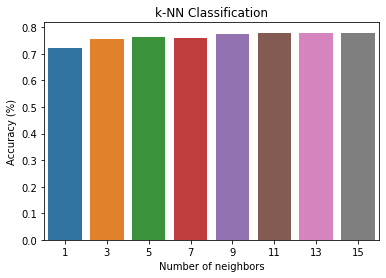

In [ ]:
gfg = sns.barplot(x = n_neighbors,y = accuracy)
gfg.set(xlabel ="Number of neighbors", ylabel = "Accuracy (%)", title ='k-NN Classification')

In [ ]:
#Re-entrenar el modelo con los datos de entrenamiento y validación para el valor de k óptimo
k_opt = n_neighbors[np.argmax(accuracy)]
print(f"El número óptimo de vecinos es {k_opt}")
X_train = pd.concat([df_train,df_val],axis=0)
y_train = np.hstack([y_train,y_val])

El número óptimo de vecinos es 13


In [ ]:
# Entrenar el clasificador con los datos de entrenamiento
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors=k_opt))])
clf.fit(X_train, y_train)
#Validar el rendimiento del clasificador con los datos de prueba
accuracy = clf.score(df_test, y_test)

print(f"La tasa de acierto de clasificación en el conjunto de test es {accuracy:0.2f}")

La tasa de acierto de clasificación en el conjunto de test es 0.79


In [ ]:
print(clf.predict(df_test.iloc[[0],:]))
print(y_test[0])

['no']
no


gender                                 female
seniorcitizen                               0
partner                                    no
dependents                                 no
tenure                                     41
phoneservice                              yes
multiplelines                              no
internetservice                           dsl
onlinesecurity                            yes
onlinebackup                               no
deviceprotection                          yes
techsupport                               yes
streamingtv                               yes
streamingmovies                           yes
contract                             one_year
paperlessbilling                          yes
paymentmethod       bank_transfer_(automatic)
monthlycharges                          79.85
totalcharges                          3320.75
Name: 3381, dtype: object